# Wyscout Data for Inter 2017-2018

In this notebooks we will learn to work with [Wyscout](https://wyscout.com/) data and to extract useful information for the tactical point of view.

For this course we will use che [Player Rank](https://github.com/mesosbrodleto/playerank) open source project owned by Pappalardo Luca, Cintia Paolo & Co.

## utilities

In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import util
import warnings
warnings.simplefilter("ignore")
path = "C:/Users/Mauro/OneDrive/Documenti/Football/Inter_2017_2018"
inter_id = 3161

**CALCULATE TIME BALL POSSESSION, TIME BALL NOT POSSESSION, TIME BALL DUELS, TIME STOPPED**

Ad ogni evento viene aggiunta l'informazione del timestamp dell'evento successivo <br>
Per ogni evento viene calcolata la durata come differenza tra timestemp dell'evento successivo e timestamp dell'evento attuale <br> <br>

1: se l'evento è "Foul" o "Interruption" o "Offside" allora la durata va ad incrementare il tempo di gioco fermo <br>
2: se l'evento è "Pass" o "Free Kick" o "Shot" allora la durata va ad incrementare il tempo di possesso relativo alla squadra a cui è associato l'evento <br>
3: se l'evento non è uno di quelli specificati ai primi due punti allora va ad incrementare il tempo di gioco in cui il possesso è conteso ("Duel", "Other on the ball", "Save attempt", "Goalkeeper leaving the line") <br> <br>

Il possesso palla di una squadra viene calcolato come percentuale del tempo di possesso di quella squadra rispetto alla somma del tempo di possesso delle due squadre

In [50]:
inter_matches = pd.read_csv(os.path.join(path, "inter_matches.csv"))
first_match = inter_matches[inter_matches.gameweek == 1][["wyId", "label"]]
first_match

,wyId,label
37,2575963,"Internazionale - Fiorentina, 3 - 0"


In [51]:
inter_matches_events = pd.read_csv(os.path.join(path, "inter_matches_events.csv"))
inter_matches_events.groupby(["eventId", "eventName"]).size()

eventId  eventName              
1        Duel                       15639
2        Foul                         899
3        Free Kick                   3660
4        Goalkeeper leaving line      106
5        Interruption                2648
6        Offside                      172
7        Others on the ball          5423
8        Pass                       35614
9        Save attempt                 361
10       Shot                         945
dtype: int64

In [52]:
inter_matches_events.matchId.unique()

array([2575963, 2575976, 2575984, 2575990, 2576001, 2576013, 2576020,
       2576034, 2576044, 2576055, 2576061, 2576075, 2576082, 2576091,
       2576104, 2576112, 2576125, 2576136, 2576145, 2576153, 2576166,
       2576174, 2576180, 2576191, 2576203, 2576210, 2576224, 2576234,
       2576245, 2576251, 2576265, 2576272, 2576281, 2576294, 2576302,
       2576315, 2576326, 2576335], dtype=int64)

In [53]:
first_match_events = inter_matches_events[inter_matches_events.matchId == first_match.wyId.iloc[0]]
first_match_events.head(3)

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,subEventId,subEventName,teamId,x_start,y_start,x_end,y_end,tags
0,8,Pass,0.924246,180460660,2575963,1H,269152,85.0,Simple pass,3176,52,50,34.0,47.0,[1801]
1,8,Pass,1.679327,180458825,2575963,1H,26518,85.0,Simple pass,3176,34,47,30.0,48.0,[1801]
2,8,Pass,2.980452,180458841,2575963,1H,20866,83.0,High pass,3176,30,48,76.0,88.0,[1801]


In [54]:
ht_first_match_events = first_match_events.query("matchPeriod == '1H'")
ft_first_match_events = first_match_events.query("matchPeriod == '2H'")
ht_first_match_events.shape, ft_first_match_events.shape

((888, 15), (809, 15))

In [55]:
#questa funzione consente di aggiungere ad ogni evento il timestamp dell'evento successivo
def get_next_event_time(data):
    nextEventSec = []
    for i in range(len(data)-1):
        next_event = data.iloc[i+1]
        nextEventSec.append(next_event.eventSec)
    data = data.reset_index(drop=True)
    data["nextEventSec"] = pd.Series(nextEventSec)
    return data

In [56]:
ht_first_match_events = get_next_event_time(ht_first_match_events)
ht_first_match_events.tail(3)

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,subEventId,subEventName,teamId,x_start,y_start,x_end,y_end,tags,nextEventSec
885,1,Duel,2814.328206,180460493,2575963,1H,338249,11.0,Ground attacking duel,3176,88,89,78.0,72.0,"[502, 703, 1801]",2815.362732
886,10,Shot,2815.362732,180460527,2575963,1H,338249,100.0,Shot,3176,78,72,100.0,100.0,"[401, 2101, 1802]",2817.873748
887,7,Others on the ball,2817.873748,180459445,2575963,1H,116349,72.0,Touch,3161,12,37,0.0,0.0,[1401],NaN


In [57]:
ft_first_match_events = get_next_event_time(ft_first_match_events)
ft_first_match_events.tail(3)

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,subEventId,subEventName,teamId,x_start,y_start,x_end,y_end,tags,nextEventSec
806,8,Pass,2930.218354,180460247,2575963,2H,116349,85.0,Simple pass,3161,38,70,53.0,91.0,[1801],2934.884163
807,8,Pass,2934.884163,180460249,2575963,2H,21094,85.0,Simple pass,3161,53,91,45.0,82.0,[1801],2935.677194
808,8,Pass,2935.677194,180460250,2575963,2H,116349,85.0,Simple pass,3161,45,82,0.0,0.0,[1802],NaN


In [58]:
#questa funzione consente di calcolare il tempo di una fase del match che deve essere specificata come parametro
'''
    phase == "possession": restituisce il tempo di possesso dell'Inter
    phase == "opponent possession": restituisce il tempo di possesso della squadra avversaria
    phase == "duels": restituisce il tempo di palla contesa
    phase == "stop": restituisce il tempo di gioco fermo
'''
def calculate_phase_time(data, phase="possession", x_range=-1):
    data = data.query("x_start > " + str(x_range) + " and x_end > " + str(x_range))
    time_poss = 0
    for i in range(len(data)-1):
        event = data.iloc[i]
        if phase == "possession":
            if event.teamId == 3161:
                if event.eventName in ["Pass", "Free Kick", "Shot"]:
                    time_poss = time_poss + (event.nextEventSec - event.eventSec)
        elif phase == "opponent possession":
            if event.teamId != 3161:
                if event.eventName in ["Pass", "Free Kick", "Shot"]:
                    time_poss = time_poss + (event.nextEventSec - event.eventSec)
        elif phase == "duels":
            if event.eventName in ["Duel", "Goalkeeper leaving line", "Others on the ball", "Save attempt"]:
                time_poss = time_poss + (event.nextEventSec - event.eventSec)
        elif phase == "stop":
            if event.eventName in ["Foul", "Interruption", "Offside"]:
                time_poss = time_poss + (event.nextEventSec - event.eventSec)      
        else:
            print("Phase not valid! Please specify one of 'possession', 'opponent possession', 'duel', 'stop'")
    mm = time_poss / 60
    ss = (mm - int(mm)) * 0.6
    time_poss = round(int(mm) + ss, 2)
    return time_poss

In [59]:
ball_possession_percentage = dict()
for match in inter_matches_events.matchId.unique():
    ht = inter_matches_events.query("matchId == " + str(match) + " and matchPeriod == '1H'")
    ft = inter_matches_events.query("matchId == " + str(match) + " and matchPeriod == '2H'")
    ht = get_next_event_time(ht)
    ft = get_next_event_time(ft)
    time_possession = calculate_phase_time(ht, "possession") + calculate_phase_time(ft, "possession")
    time_opponent_possession = calculate_phase_time(ht, "opponent possession") + calculate_phase_time(ft, "opponent possession")
    ball_possession_percentage[match] = int(round(time_possession / (time_possession + time_opponent_possession) * 100))    

In [60]:
ball_possession_percentage

{2575963: 52,
 2575976: 53,
 2575984: 63,
 2575990: 70,
 2576001: 56,
 2576013: 61,
 2576020: 64,
 2576034: 39,
 2576044: 37,
 2576055: 54,
 2576061: 59,
 2576075: 52,
 2576082: 51,
 2576091: 55,
 2576104: 68,
 2576112: 49,
 2576125: 69,
 2576136: 70,
 2576145: 56,
 2576153: 46,
 2576166: 54,
 2576174: 55,
 2576180: 64,
 2576191: 54,
 2576203: 65,
 2576210: 53,
 2576224: 55,
 2576234: 38,
 2576245: 62,
 2576251: 67,
 2576265: 63,
 2576272: 53,
 2576281: 74,
 2576294: 57,
 2576302: 42,
 2576315: 63,
 2576326: 72,
 2576335: 62}

In [61]:
inter_matches = pd.read_csv(os.path.join(path, "inter_matches.csv"))
inter_matches["ball_possession_percentage"] = 0
for match_id in ball_possession_percentage:
    inter_matches.at[inter_matches.wyId == match_id, "ball_possession_percentage"] = ball_possession_percentage[match_id]
inter_matches.head(3)

,competitionId,date,dateutc,duration,gameweek,label,roundId,seasonId,status,teamsData,venue,winner,wyId,referee,firstAssistant,secondAssistant,fourthOfficial,firstAdditionalAssistant,secondAdditionalAssistant,ball_possession_percentage
0,524,"May 20, 2018 at 8:45:00 PM GMT+2",2018-05-20 18:45:00,Regular,38,"Lazio - Internazionale, 2 - 3",4406278,181248,Played,"{'3162': {'scoreET': 0, 'coachId': 251025, 'si...",NaN,3161,2576335,377206,NaN,384945,377241,NaN,NaN,62
1,524,"May 12, 2018 at 8:45:00 PM GMT+2",2018-05-12 18:45:00,Regular,37,"Internazionale - Sassuolo, 1 - 2",4406278,181248,Played,"{'3315': {'scoreET': 0, 'coachId': 20603, 'sid...",NaN,3315,2576326,377271,396642.0,393628,377261,NaN,NaN,72
2,524,"May 6, 2018 at 12:30:00 PM GMT+2",2018-05-06 10:30:00,Regular,36,"Udinese - Internazionale, 0 - 4",4406278,181248,Played,"{'3163': {'scoreET': 0, 'coachId': 267555, 'si...",NaN,3161,2576315,377232,379461.0,381926,377243,NaN,NaN,63


**BALL POSSESSION PERCENTAGE EVOLUTION DURING THE SEASON**

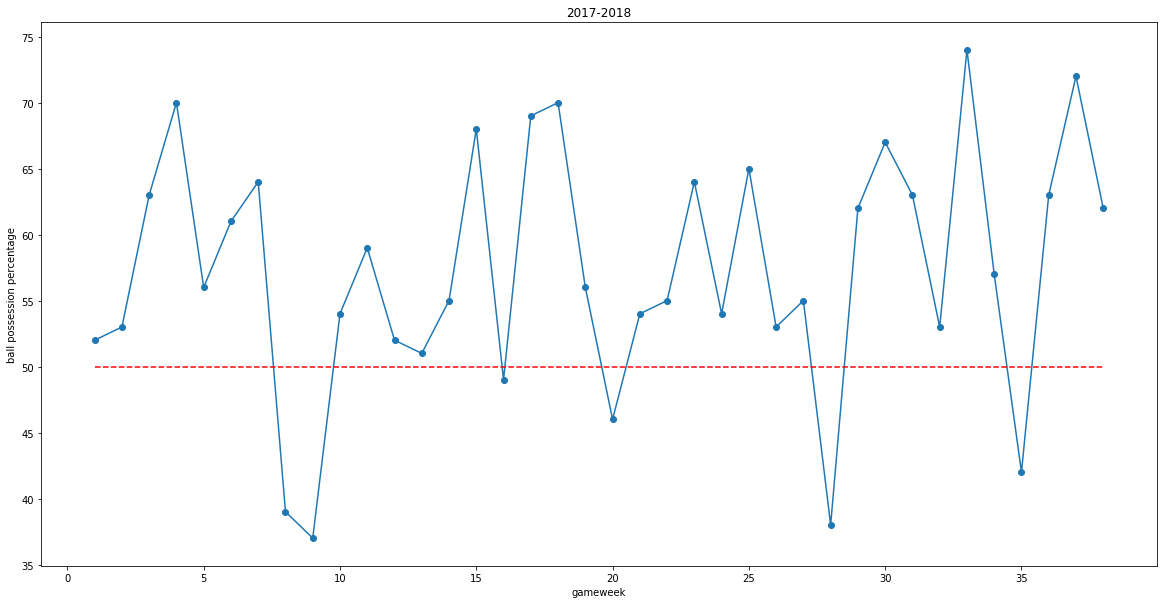

In [62]:
inter_matches = inter_matches.sort_values(by="gameweek")
plt.figure(figsize=(20, 10))
plt.plot(inter_matches.gameweek, inter_matches.ball_possession_percentage)
plt.plot(inter_matches.gameweek, [50] * 38, linestyle="--", color="red")
plt.scatter(inter_matches.gameweek, inter_matches.ball_possession_percentage)
plt.title("2017-2018")
plt.xlabel("gameweek")
plt.ylabel("ball possession percentage")
plt.show()

In [63]:
print("Match with less ball possession percentage than the opponent")
for match in ball_possession_percentage.keys():
    if ball_possession_percentage[match] < 50:
        print(inter_matches[inter_matches.wyId == match].iloc[0].label)

Match with less ball possession percentage than the opponent
Internazionale - Milan, 3 - 2
Napoli - Internazionale, 0 - 0
Juventus - Internazionale, 0 - 0
Fiorentina - Internazionale, 1 - 1
Internazionale - Napoli, 0 - 0
Internazionale - Juventus, 2 - 3


In [64]:
print("Top 5 matches for ball possession percentage")
inter_matches.sort_values(by="ball_possession_percentage", ascending=False).iloc[0:5][["label", "ball_possession_percentage"]]

Top 5 matches for ball possession percentage


,label,ball_possession_percentage
5,"Internazionale - Cagliari, 4 - 0",74
1,"Internazionale - Sassuolo, 1 - 2",72
34,"Crotone - Internazionale, 0 - 2",70
20,"Sassuolo - Internazionale, 1 - 0",70
21,"Internazionale - Udinese, 1 - 3",69


**CALCULATE BALL POSSESSION PERCENTAGE IN THE OPPONENT FIELD (SECOND HALF PITCH)**

In [65]:
ball_possession_percentage_opponent_field = dict()
for match in inter_matches_events.matchId.unique():
    ht = inter_matches_events.query("matchId == " + str(match) + " and matchPeriod == '1H'")
    ft = inter_matches_events.query("matchId == " + str(match) + " and matchPeriod == '2H'")
    ht = get_next_event_time(ht)
    ft = get_next_event_time(ft)
    time_possession = calculate_phase_time(ht, "possession") + calculate_phase_time(ft, "possession")
    time_possession_1 = calculate_phase_time(ht, "possession", 50) + calculate_phase_time(ft, "possession", 50)
    ball_possession_percentage_opponent_field[match] = int(round(time_possession / (time_possession + time_possession_1) * 100))    

In [66]:
inter_matches["ball_possession_percentage_opponent_field"] = 0
for match_id in ball_possession_percentage_opponent_field:
    inter_matches.at[inter_matches.wyId == match_id, "ball_possession_percentage_opponent_field"] = ball_possession_percentage_opponent_field[match_id]
inter_matches.head(3)

,competitionId,date,dateutc,duration,gameweek,label,roundId,seasonId,status,teamsData,...,winner,wyId,referee,firstAssistant,secondAssistant,fourthOfficial,firstAdditionalAssistant,secondAdditionalAssistant,ball_possession_percentage,ball_possession_percentage_opponent_field
37,524,"August 20, 2017 at 8:45:00 PM GMT+2",2017-08-20 18:45:00,Regular,1,"Internazionale - Fiorentina, 3 - 0",4406278,181248,Played,"{'3161': {'scoreET': 0, 'coachId': 101547, 'si...",...,3161,2575963,377210,388411.0,379464,377257,377241.0,377243.0,52,75
36,524,"August 26, 2017 at 8:45:00 PM GMT+2",2017-08-26 18:45:00,Regular,2,"Roma - Internazionale, 1 - 3",4406278,181248,Played,"{'3158': {'scoreET': 0, 'coachId': 210119, 'si...",...,3161,2575976,377253,388407.0,383492,377263,377228.0,377249.0,53,70
35,524,"September 10, 2017 at 12:30:00 PM GMT+2",2017-09-10 10:30:00,Regular,3,"Internazionale - SPAL, 2 - 0",4406278,181248,Played,"{'3204': {'scoreET': 0, 'coachId': 357389, 'si...",...,3161,2575984,377254,383498.0,396657,377268,377232.0,396657.0,63,64


**BALL POSSESSION PERCENTAGE IN THE OPPONENT FIELD - EVOLUTION DURING THE SEASON**

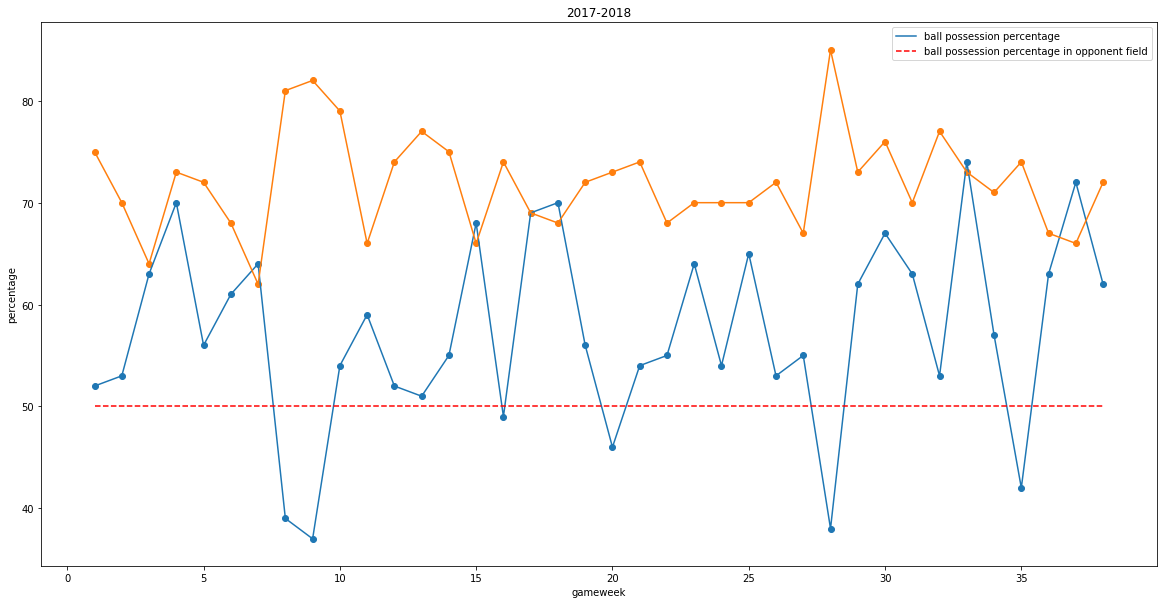

In [67]:
inter_matches = inter_matches.sort_values(by="gameweek")
plt.figure(figsize=(20, 10))
plt.plot(inter_matches.gameweek, inter_matches.ball_possession_percentage)
plt.plot(inter_matches.gameweek, [50] * 38, linestyle="--", color="red")
plt.scatter(inter_matches.gameweek, inter_matches.ball_possession_percentage)
plt.plot(inter_matches.gameweek, inter_matches.ball_possession_percentage_opponent_field)
plt.scatter(inter_matches.gameweek, inter_matches.ball_possession_percentage_opponent_field)
plt.title("2017-2018")
plt.xlabel("gameweek")
plt.ylabel("percentage")
plt.legend(["ball possession percentage", "ball possession percentage in opponent field"])
plt.show()

In [68]:
print("Top 5 matches for ball possession percentage in the opponent field")
inter_matches.sort_values(by="ball_possession_percentage_opponent_field", ascending=False).iloc[0:5][["label", "ball_possession_percentage_opponent_field", "ball_possession_percentage"]]

Top 5 matches for ball possession percentage in the opponent field


,label,ball_possession_percentage_opponent_field,ball_possession_percentage
11,"Internazionale - Napoli, 0 - 0",85,38
29,"Napoli - Internazionale, 0 - 0",82,37
30,"Internazionale - Milan, 3 - 2",81,39
28,"Internazionale - Sampdoria, 3 - 2",79,54
6,"Atalanta - Internazionale, 0 - 0",77,53


In [69]:
print("Bottom 5 matches for ball possession percentage in the opponent field")
inter_matches.sort_values(by="ball_possession_percentage_opponent_field", ascending=False).iloc[33:38][["label", "ball_possession_percentage_opponent_field", "ball_possession_percentage"]]

Bottom 5 matches for ball possession percentage in the opponent field


,label,ball_possession_percentage_opponent_field,ball_possession_percentage
23,"Internazionale - Chievo, 5 - 0",66,68
1,"Internazionale - Sassuolo, 1 - 2",66,72
27,"Hellas Verona - Internazionale, 1 - 2",66,59
35,"Internazionale - SPAL, 2 - 0",64,63
31,"Benevento - Internazionale, 1 - 2",62,64


**CALCULATE ARMONIC MEAN BETWEEN BALL POSSESSION PERCENTAGE AND BALL POSSESSION PERCENTAGE IN THE OPPONENT FIELD**

**dangerousness_ball_possession** = 2 * ((ball_possession_percentage * ball_possession_percentage_opponent_field) / (ball_possession_percentage + ball_possession_percentage_opponent_field))

In [70]:
inter_matches["dangerousness_ball_possession"] = round(2 * ((inter_matches.ball_possession_percentage * inter_matches.ball_possession_percentage_opponent_field) / (inter_matches.ball_possession_percentage + inter_matches.ball_possession_percentage_opponent_field)), 2)
inter_matches["dangerousness_ball_possession"] = inter_matches["dangerousness_ball_possession"].astype(int)
inter_matches.head(3)

,competitionId,date,dateutc,duration,gameweek,label,roundId,seasonId,status,teamsData,...,wyId,referee,firstAssistant,secondAssistant,fourthOfficial,firstAdditionalAssistant,secondAdditionalAssistant,ball_possession_percentage,ball_possession_percentage_opponent_field,dangerousness_ball_possession
37,524,"August 20, 2017 at 8:45:00 PM GMT+2",2017-08-20 18:45:00,Regular,1,"Internazionale - Fiorentina, 3 - 0",4406278,181248,Played,"{'3161': {'scoreET': 0, 'coachId': 101547, 'si...",...,2575963,377210,388411.0,379464,377257,377241.0,377243.0,52,75,61
36,524,"August 26, 2017 at 8:45:00 PM GMT+2",2017-08-26 18:45:00,Regular,2,"Roma - Internazionale, 1 - 3",4406278,181248,Played,"{'3158': {'scoreET': 0, 'coachId': 210119, 'si...",...,2575976,377253,388407.0,383492,377263,377228.0,377249.0,53,70,60
35,524,"September 10, 2017 at 12:30:00 PM GMT+2",2017-09-10 10:30:00,Regular,3,"Internazionale - SPAL, 2 - 0",4406278,181248,Played,"{'3204': {'scoreET': 0, 'coachId': 357389, 'si...",...,2575984,377254,383498.0,396657,377268,377232.0,396657.0,63,64,63


In [71]:
print("Top 5 matches for dangerousness ball possession")
inter_matches.sort_values(by="dangerousness_ball_possession", ascending=False).iloc[0:5][["label", "dangerousness_ball_possession", "ball_possession_percentage_opponent_field", "ball_possession_percentage"]]

Top 5 matches for dangerousness ball possession


,label,dangerousness_ball_possession,ball_possession_percentage_opponent_field,ball_possession_percentage
5,"Internazionale - Cagliari, 4 - 0",73,73,74
34,"Crotone - Internazionale, 0 - 2",71,73,70
9,"Internazionale - Hellas Verona, 3 - 0",71,76,67
21,"Internazionale - Udinese, 1 - 3",69,69,69
1,"Internazionale - Sassuolo, 1 - 2",68,66,72


In [72]:
print("Bottom 5 matches for dangerousness ball possession")
inter_matches.sort_values(by="dangerousness_ball_possession", ascending=False).iloc[33:38][["label", "dangerousness_ball_possession", "ball_possession_percentage_opponent_field", "ball_possession_percentage"]]

Bottom 5 matches for dangerousness ball possession


,label,dangerousness_ball_possession,ball_possession_percentage_opponent_field,ball_possession_percentage
18,"Fiorentina - Internazionale, 1 - 1",56,73,46
3,"Internazionale - Juventus, 2 - 3",53,74,42
11,"Internazionale - Napoli, 0 - 0",52,85,38
30,"Internazionale - Milan, 3 - 2",52,81,39
29,"Napoli - Internazionale, 0 - 0",50,82,37
